In [27]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from seaborn import countplot
from tqdm.auto import tqdm

In [28]:
# Make use of GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
# Dataset
class PMTDataset(Dataset):
    def __init__(self, csv_file):

        self.df = pd.read_csv(csv_file, encoding= 'unicode_escape')

        # Encode the label i.e. the 'isKilled' column --> no=1 and yes=0
        self.y = torch.tensor(pd.Series(np.where(self.df.isKilled.values == 'no', 1., 0.), self.df.index).to_numpy()).to(device)

        # Encode the categorical features to one hot encodings
        self.df['operator'] = pd.Categorical(self.df['operator'], categories=['T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12','T13','T14'])
        self.df['methodReturn'] = pd.Categorical(self.df['methodReturn'], categories=['I','V','Z','method','D','[D','[[D','J','[I','C','[J','[C','[S',
                                                                                      'F','[F','[B','S','B','[Z','[[S','[[B','[[Z'])
        self.X = torch.tensor(pd.get_dummies(self.df, columns=["operator", "methodReturn"]).drop("isKilled", axis=1).to_numpy()).to(device)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_data(self):
        return self.X, self.y


In [30]:
# Model
class Net(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, h3_size, h4_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, h1_size)
        self.relu = nn.Tanh()
        self.l2 = nn.Linear(h1_size, h2_size)
        self.l3 = nn.Linear(h2_size, h3_size)
        self.l4 = nn.Linear(h3_size, h4_size)
        self.l5 = nn.Linear(h4_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x.float())
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        return out
        

In [45]:
# Hyperparameters
input_size = 49
h1_size = 40
h2_size = 32
h3_size = 16
h4_size = 8
num_classes = 1
num_epochs = 3
num_batches = 500
learning_rate = 0.01

In [46]:
train_dataset = PMTDataset("training_data.csv")
train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset)//num_batches +1, shuffle=True)
test_dataset = PMTDataset("testing_data.csv")
# test_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([1184, 49]) torch.Size([1184])


In [47]:
model = Net(input_size, h1_size, h2_size, h3_size, h4_size, num_classes).to(device)

#loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# LR scheduler
lambda1 = lambda epoch: 0.5
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lambda1)

In [48]:
def confusion(truth, prediction):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    print(true_positives, false_negatives)
    print(false_positives, true_negatives)
    return [[true_positives, false_positives], [false_negatives, true_negatives]]

# testing loop
def test():
    with torch.no_grad():
        n_correct = 0

        features, labels = test_dataset.get_data()

        outputs = model(features)

        predictions = torch.round(torch.sigmoid(outputs)).view(-1)
        # print(predictions.shape, labels.shape, type(labels))
        
        n_correct = torch.sum(predictions == labels).item()
        # confusion(labels, predictions)

        acc = 100.0 * n_correct / len(labels)
        # print('accuracy = %.3f' % acc)
        return acc

# testing loop
def train():
    with torch.no_grad():
        n_correct = 0

        features, labels = train_dataset.get_data()

        outputs = model(features)

        predictions = torch.round(torch.sigmoid(outputs)).view(-1)
        # print(predictions.shape, labels.shape, type(labels))
        
        n_correct = torch.sum(predictions == labels).item()
        # confusion(labels, predictions)

        acc = 100.0 * n_correct / len(labels)
        # print('accuracy = %.3f' % acc)
        return acc

In [49]:
#training loop
total_steps = len(train_loader)
for epoch in range(num_epochs):
    pbar = tqdm(train_loader)
    for (features, labels) in pbar:
        # print(features.dtype, labels.dtype)
        features = features.to(device)
        labels = labels.to(device)

        #forward
        outputs = model(features)
        #print(outputs.dtype)
        loss = criterion(outputs, labels.unsqueeze(1))

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f'loss = {loss.item():.4f}, train accuracy = {train():.3f}, test accuracy = {test():.3f}')
        #if (i+1) % 100 == 0:
        # print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{total_steps}, loss = {loss.item():.4f}')
    scheduler.step()
    

loss = 0.1340, train accuracy = 94.194, test accuracy = 85.597: 100%|██████████| 500/500 [00:21<00:00, 23.27it/s]
loss = 0.1374, train accuracy = 94.403, test accuracy = 88.629: 100%|██████████| 500/500 [00:21<00:00, 23.44it/s]
loss = 0.1319, train accuracy = 94.478, test accuracy = 88.141: 100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


In [43]:
features = pd.read_csv('training_data.csv', encoding= 'unicode_escape')

In [44]:
features = pd.get_dummies(features, columns=["operator", "methodReturn"]).drop("isKilled", axis=1)

In [51]:
features = torch.tensor(features.values)

In [18]:
data, label = train_dataset.get_data()
print(data)
print(label)

tensor([[2., 0., 1.,  ..., 0., 0., 0.],
        [2., 0., 1.,  ..., 0., 0., 0.],
        [2., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [3., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [2., 0., 1.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
tensor([1., 1., 1.,  ..., 1., 1., 0.], device='cuda:0', dtype=torch.float64)


In [12]:
torch.save(model, 'C:\\Users\\prava\\OneDrive\\Documents\\UVA\\Semester 2\\CS6316 - Machine Learning\\Project\\models\\32-32--20--tanh--9465.pt')

<AxesSubplot:xlabel='isKilled', ylabel='count'>

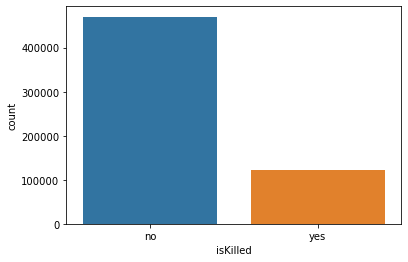

In [3]:
df = pd.read_csv('training_data.csv', encoding= 'unicode_escape')

<AxesSubplot:xlabel='operator', ylabel='count'>

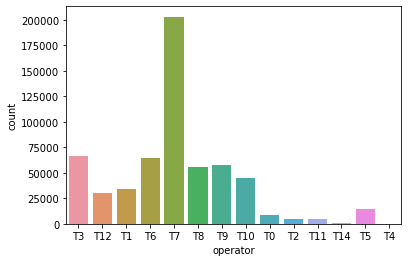

In [4]:
countplot(x='operator', data=df)


<AxesSubplot:xlabel='methodReturn', ylabel='count'>

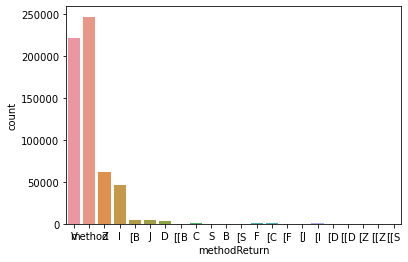

In [5]:
countplot(x='methodReturn', data=df)

In [8]:
dft = pd.read_csv('testing_data.csv', encoding= 'unicode_escape')

<AxesSubplot:xlabel='isKilled', ylabel='count'>

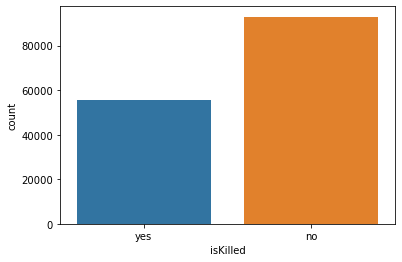

In [9]:
countplot(x='isKilled', data=dft)

<AxesSubplot:xlabel='operator', ylabel='count'>

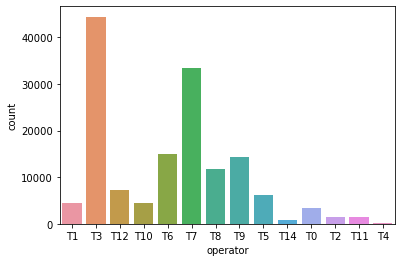

In [10]:
countplot(x='operator', data=dft)

<AxesSubplot:xlabel='methodReturn', ylabel='count'>

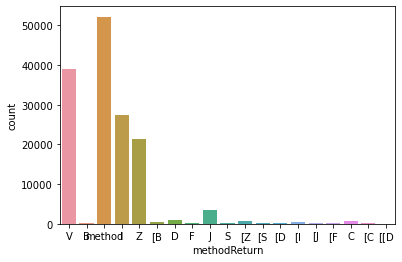

In [11]:
countplot(x='methodReturn', data=dft)

<AxesSubplot:xlabel='methodReturn', ylabel='count'>

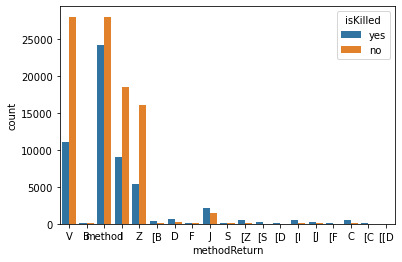

In [12]:
countplot(x='methodReturn', hue='isKilled', data=dft)

<AxesSubplot:xlabel='operator', ylabel='count'>

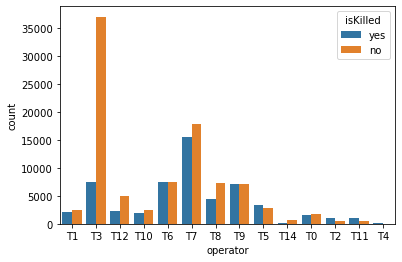

In [13]:
countplot(x='operator', hue='isKilled', data=dft)

<AxesSubplot:xlabel='operator', ylabel='count'>

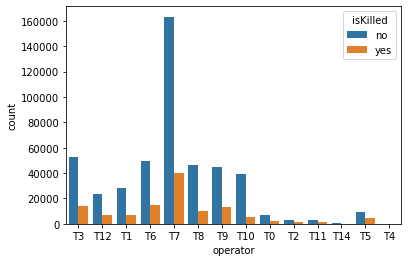

In [15]:
countplot(x='operator', hue='isKilled', data=df)

<AxesSubplot:xlabel='methodReturn', ylabel='count'>

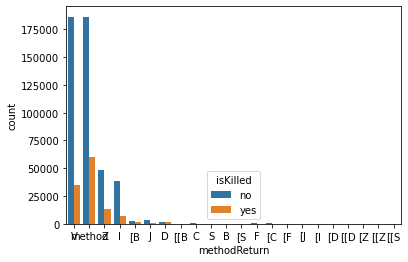

In [17]:
countplot(x='methodReturn', hue='isKilled', data=df)

Index(['DepthTree', 'NumSubclass', 'McCabe', 'LOC', 'DepthNested', 'CA', 'CE',
       'Instability', 'numCovered', 'operator', 'methodReturn',
       'numTestsCover', 'mutantAssert', 'classAssert'],
      dtype='object')